Reference:
https://github.com/jpdeleon/toi0179/blob/main/notebooks/fig_rv_model_mass_constraint.ipynb

In [1]:
import os
import numpy as np
import matplotlib.pyplot as pl
import pandas as pd
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy import constants as con

import subprocess
from tqdm import tqdm

In [2]:
df_all=pd.read_csv('../data/rv/TOI1696_rv_all.dat', sep=',')
df_yj=pd.read_csv('../data/rv/TOI1696_rv_yj.dat', sep=',')
df_yj

,bjd,rv,rv_err
0,2.459245e+06,-0.053392,0.01623
1,2.459488e+06,-0.029687,0.01424
2,2.459508e+06,0.068336,0.01874
3,2.459508e+06,0.061334,0.01405
4,2.459510e+06,0.105841,0.01895
5,2.459510e+06,0.045615,0.01487
6,2.459515e+06,-0.019704,0.01701
7,2.459515e+06,0.000000,0.01431
8,2.459531e+06,-0.046459,0.01720


In [3]:
df = df_all

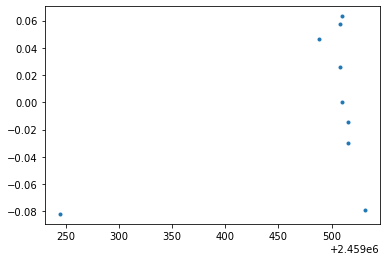

In [4]:
pl.plot(df['bjd'],df['rv'], '.')

In [5]:
T0 = 2459206.74743
P = 2.50079 #day
Ms = 0.261#solar mass
Mp = 68 #earth mass, tentative

a_rs = (0.023 * con.au/ (0.268 * con.R_sun)).value

b = 0.49
inc = np.arccos(b / a_rs)#rad

In [6]:
def rv_model_circle(params, tm):  
    t0, p, ms, mp, i = params
    p_u = p * u.day
    mp_u = mp * con.M_earth
    ms_u = ms * con.M_sun
    
    K = (2 * np.pi * con.G / p_u)**(1/3.)* mp_u*np.sin(i)/(ms_u+mp_u)**(2/3.)
    rv = K.si * np.sin(2 * np.pi / p * (tm-t0))
    return rv.value/1000

In [7]:
params_pr=[T0, P, Ms, Mp, inc]

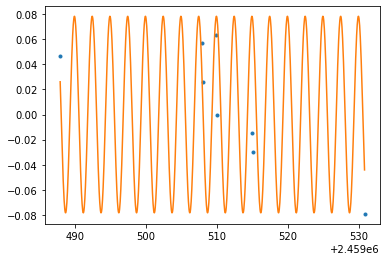

In [8]:
time = np.linspace(df['bjd'][1], df['bjd'][len(df)-1], 1000)
RV_model = rv_model_circle(params_pr,time)
pl.plot(df['bjd'][1:],df['rv'][1:], '.')
pl.plot(time, RV_model)

In [9]:
# 横軸phaseでやる

def phase(OBS_JD, T0, P):
    n = np.floor((OBS_JD-T0)/P)
    tr_before = T0 + n * P             #the JD of the last transit (phase=0) before the observation
    ph = (OBS_JD - tr_before)/P
    return ph

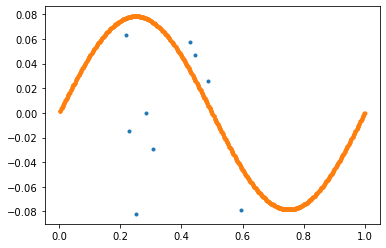

In [10]:
pl.plot(phase(df['bjd'], T0, P), df['rv'], '.')
pl.plot(phase(time, T0, P), RV_model, '.')

iとbを対応付けて、トランジットとRVを同時フィットできた方がいいのかなぁ…
RVの精度が悪いことを考えると、iとかMsとかは固定がいいのかな？

# Fitting

- params_setにする
- 何を動かすか
- MCMC
- 最終的には横軸phaseにする

# まずはKだけを動かす

In [21]:
def rv_model_K(K, t0, p, tm):  
    rv = K* np.sin(2 * np.pi / p * (tm-t0))
    return rv

In [22]:
RV_model_dot=rv_model_K(0.08, T0, P, df['bjd'])
RV_model_dot

0    0.080000
1    0.026684
2    0.035064
3    0.006157
4    0.078341
5    0.078004
6    0.079317
7    0.074655
8   -0.045049
Name: bjd, dtype: float64

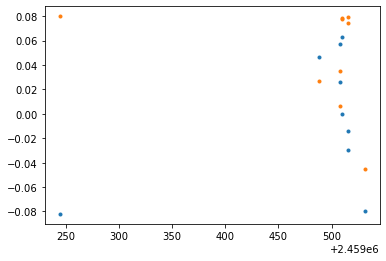

In [23]:
pl.plot(df['bjd'], df['rv'], '.')
pl.plot(df['bjd'], RV_model_dot, '.')

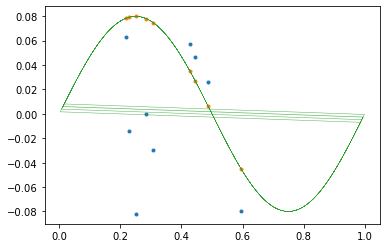

In [27]:
pl.plot(phase(df['bjd'], T0, P), df['rv'], '.')
pl.plot(phase(df['bjd'], T0, P), RV_model_dot, '.')

RV_model=rv_model_K(0.08, T0, P, time)
pl.plot(phase(time, T0, P), RV_model, '-', lw=0.1)

In [33]:
time_obs = df['bjd']
rv_obs = df['rv']
rv_e_obs = df['rv_err']

time_pr = np.linspace(df['bjd'][0], df['bjd'][len(df)-1], 10000)

In [ ]:
def logprob()